In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


class   fake  real
split             
dev    10295  2548
eval   26412  6334
train  10660  2525


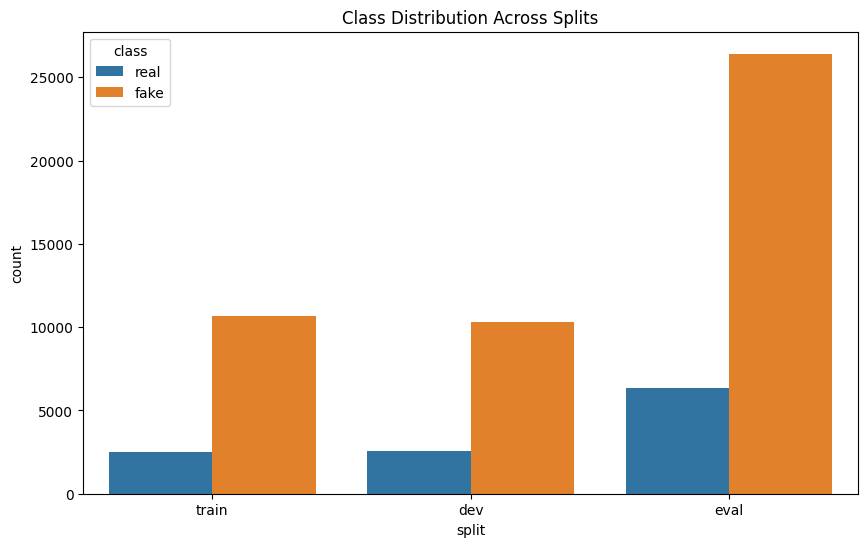

In [ ]:
dataset_path = r"C:\Users\Sherwyn\Downloads\Projects\Python\DeepFake\Dataset"

def analyze_dataset(base_path):
    splits = ['train', 'dev', 'eval']
    classes = ['real', 'fake']
    
    data = []
    for split in splits:
        for cls in classes:
            path = os.path.join(base_path, split, cls)
            count = len(os.listdir(path))
            data.append({'split': split, 'class': cls, 'count': count})
            
    df = pd.DataFrame(data)
    return df

dataset_stats = analyze_dataset(dataset_path)
print(dataset_stats.pivot(index='split', columns='class', values='count'))

plt.figure(figsize=(10, 6))
sns.barplot(x='split', y='count', hue='class', data=dataset_stats)
plt.title('Class Distribution Across Splits')
plt.show()

Sample Rate: 16000 Hz
Duration: 2.73 seconds
Audio Signal Shape: (43639,)
Zero-Crossing Rate: 0.0578


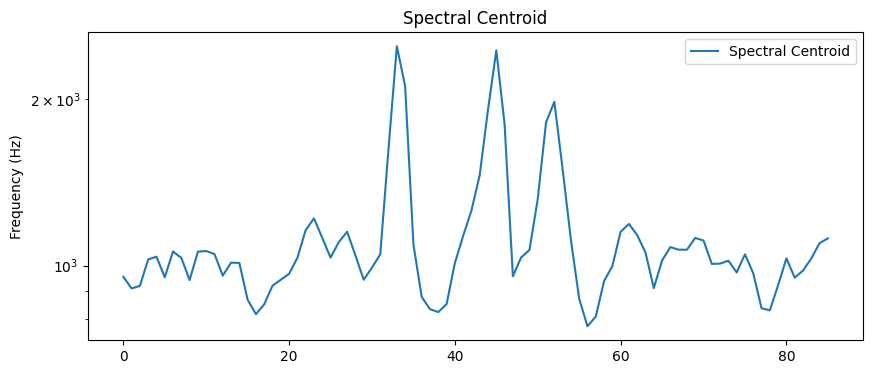

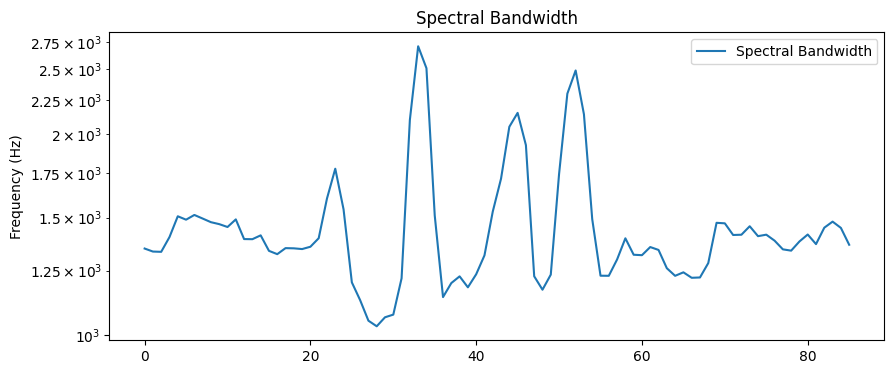

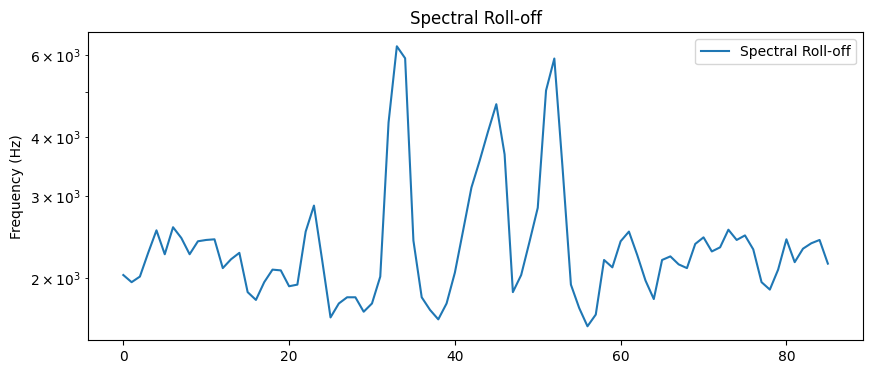

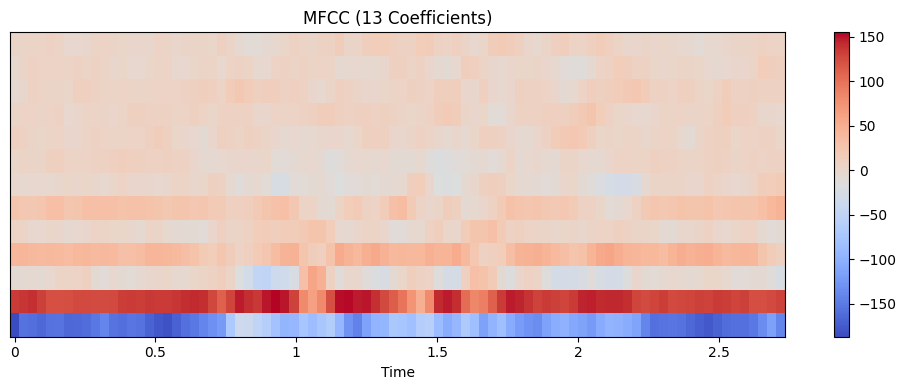

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Load an audio file
filename = r"C:\\Users\\Sherwyn\\Downloads\\Projects\\Python\\DeepFake\\Dataset\\train\\real\\A_005_0_B.wav"
y, sr = librosa.load(filename, sr=None)

# Get duration of the audio
duration = librosa.get_duration(y=y, sr=sr)
print(f"Sample Rate: {sr} Hz")
print(f"Duration: {duration:.2f} seconds")
print(f"Audio Signal Shape: {y.shape}")

#Zero-Crossing Rate
zero_crossings = librosa.zero_crossings(y, pad=False)
zcr_rate = np.sum(zero_crossings) / len(y)
print(f"Zero-Crossing Rate: {zcr_rate:.4f}")

#Spectral Centroid
spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
plt.figure(figsize=(10, 4))
plt.semilogy(spectral_centroids.T, label='Spectral Centroid')
plt.ylabel('Frequency (Hz)')
plt.title('Spectral Centroid')
plt.legend(loc='upper right')
plt.show()

#Spectral Bandwidth
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
plt.figure(figsize=(10, 4))
plt.semilogy(spectral_bandwidth.T, label='Spectral Bandwidth')
plt.ylabel('Frequency (Hz)')
plt.title('Spectral Bandwidth')
plt.legend(loc='upper right')
plt.show()

#Spectral Roll-off
spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
plt.figure(figsize=(10, 4))
plt.semilogy(spectral_rolloff.T, label='Spectral Roll-off')
plt.ylabel('Frequency (Hz)')
plt.title('Spectral Roll-off')
plt.legend(loc='upper right')
plt.show()

#MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar()
plt.title('MFCC (13 Coefficients)')
plt.tight_layout()
plt.show()


In [ ]:
def extract_mfcc_features(filename, n_mfcc=13):
    y, sr = librosa.load(filename, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)
    feature_vector = np.concatenate((mfcc_mean, mfcc_std))
    return feature_vector


In [5]:
import os

def load_features_from_directory(directory_path, n_mfcc=13):
    features = []
    file_names = []  # Optional: to keep track of filenames
    for file in os.listdir(directory_path):
        if file.endswith('.wav'):
            file_path = os.path.join(directory_path, file)
            feature_vector = extract_mfcc_features(file_path, n_mfcc=n_mfcc)
            features.append(feature_vector)
            file_names.append(file)
    return np.array(features), file_names

# Example directory paths for fake and real audio files (update these paths as needed)
fake_dir = r"C:\Users\Sherwyn\Downloads\Projects\Python\DeepFake\Dataset\train\fake"
real_dir = r"C:\Users\Sherwyn\Downloads\Projects\Python\DeepFake\Dataset\train\real"

# Load features for each class
X_fake, fake_files = load_features_from_directory(fake_dir, n_mfcc=13)
X_real, real_files = load_features_from_directory(real_dir, n_mfcc=13)

print("Fake features shape:", X_fake.shape)  # Expected: (number_of_fake_files, 26)
print("Real features shape:", X_real.shape)  # Expected: (number_of_real_files, 26)


Fake features shape: (10660, 26)
Real features shape: (2525, 26)


In [6]:
# Create labels: 0 for fake, 1 for real
y_fake = np.zeros(X_fake.shape[0], dtype=int)
y_real = np.ones(X_real.shape[0], dtype=int)

# Stack features and labels
X_train = np.vstack((X_fake, X_real))
y_train = np.concatenate((y_fake, y_real))

print("Combined training set shape:", X_train.shape)
print("Training labels distribution:", np.unique(y_train, return_counts=True))


Combined training set shape: (13185, 26)
Training labels distribution: (array([0, 1]), array([10660,  2525]))


In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

print("Original distribution:", Counter(y_train))
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

print("Resampled distribution:", Counter(y_resampled))


Original distribution: Counter({np.int64(0): 10660, np.int64(1): 2525})
Resampled distribution: Counter({np.int64(0): 10660, np.int64(1): 10660})


In [ ]:
import pandas as pd

# Convert the features array into a DataFrame.
# Each row corresponds to one audio sample, and each column to a feature.
df_features = pd.DataFrame(X_train)

# Add theese labels as a new column
df_features['label'] = y_train

df_features.head()


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,label
0,-191.971497,118.298965,-28.662428,30.930489,0.734652,16.357052,0.512241,-4.494188,2.503700,-1.973033,...,22.915527,11.850455,11.762999,12.161544,10.317286,11.465570,10.472373,8.263681,6.253169,0
1,-217.288391,116.164505,15.024509,32.020199,16.623932,13.545458,-4.093700,0.018937,5.533595,8.699161,...,15.104014,13.951838,16.004261,11.728854,8.969706,7.588422,8.688404,8.756394,8.870029,0
2,-124.386627,123.388359,-18.295412,27.288525,8.977374,4.045929,-6.140698,-1.535464,-0.619506,2.353480,...,14.905896,10.124841,8.980715,7.104796,10.051600,6.117742,5.892004,6.342057,5.387594,0
3,-288.276459,119.512337,-6.566257,27.623133,5.877469,22.937798,-0.531199,2.179357,10.072868,10.011670,...,18.353388,8.387858,10.349125,14.883123,9.890212,8.259058,13.353674,9.775669,6.900864,0
4,-191.904083,136.176865,-24.540594,46.122086,10.140543,17.592983,7.181233,-11.822989,-1.799789,-0.630411,...,15.247070,19.836809,11.704630,10.222929,9.860341,10.280889,8.926976,7.838988,8.589582,0


What the Output Represents
Rows as Audio Samples:

Each row in the DataFrame represents one audio sample from your training dataset.

For example, row index 0 contains the feature information extracted from one audio file.

Columns 0 to 25:

These columns are your numerical features derived from the MFCC extraction process.

Since you set n_mfcc=13 and then computed two sets of statistics (mean and standard deviation) for each coefficient, you get 13 means and 13 standard deviations, making a total of 26 features per sample.

Columns 0–12: Represent the mean values of the 13 MFCC coefficients.

Columns 13–25: Represent the standard deviation (std) values of the 13 MFCC coefficients.

These features capture the spectral properties of the audio, providing a summary of the audio's frequency content and how it varies over time.

Label Column:

The final column, labeled label, contains the class labels.

In your case, a value of 0 means the audio sample is fake, and a value of 1 means it is real.

For instance, in the first row (index 0), the label is 0, indicating that this sample is from the fake class.

In [9]:
df_features.describe()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,label
count,13185.000000,13185.000000,13185.000000,13185.000000,13185.000000,13185.000000,13185.000000,13185.000000,13185.000000,13185.000000,...,13185.000000,13185.000000,13185.000000,13185.000000,13185.000000,13185.000000,13185.000000,13185.000000,13185.000000,13185.000000
mean,-178.503571,120.317703,-3.112728,33.258209,2.525808,13.125817,-2.675781,-2.510688,2.578252,2.001035,...,15.150306,12.654090,10.629827,11.084830,9.535083,8.735169,8.061884,7.255114,6.924621,0.191505
std,56.569401,14.388311,13.865318,10.246736,8.536918,6.638049,6.094556,7.361274,6.219081,5.307193,...,5.037691,3.489625,3.076354,3.360745,2.560929,2.450857,2.031804,1.747890,1.804716,0.393501
min,-357.377777,62.816509,-54.238586,-11.283857,-35.123081,-15.522937,-32.175106,-29.255346,-22.486982,-21.369722,...,3.054486,3.270075,3.338605,3.455407,3.778904,2.992867,2.741304,2.698283,3.109181,0.000000
25%,-221.734726,111.372749,-11.115544,27.459166,-2.639140,8.919781,-6.673660,-5.464611,-0.088006,0.071939,...,11.350597,10.011785,8.272556,8.493075,7.493866,6.895405,6.494034,5.926713,5.563932,0.000000
50%,-178.558167,119.750427,-2.317568,33.670113,2.842487,13.101919,-2.048184,-0.894301,3.360826,3.028747,...,14.338881,12.326381,10.219996,10.602116,9.131671,8.412820,7.820954,7.020230,6.651354,0.000000
75%,-139.605804,129.012100,5.886300,40.174400,8.595044,17.839630,1.475842,2.330238,6.529912,5.330945,...,18.181896,14.909614,12.708824,13.279476,11.336356,10.195065,9.394934,8.379929,8.020983,0.000000
max,-2.584084,189.839157,40.581547,69.485664,27.461651,32.175930,15.024822,21.649546,19.292276,19.842207,...,40.564564,30.207773,23.594368,25.545240,19.869490,22.065226,19.354834,16.236158,16.708685,1.000000


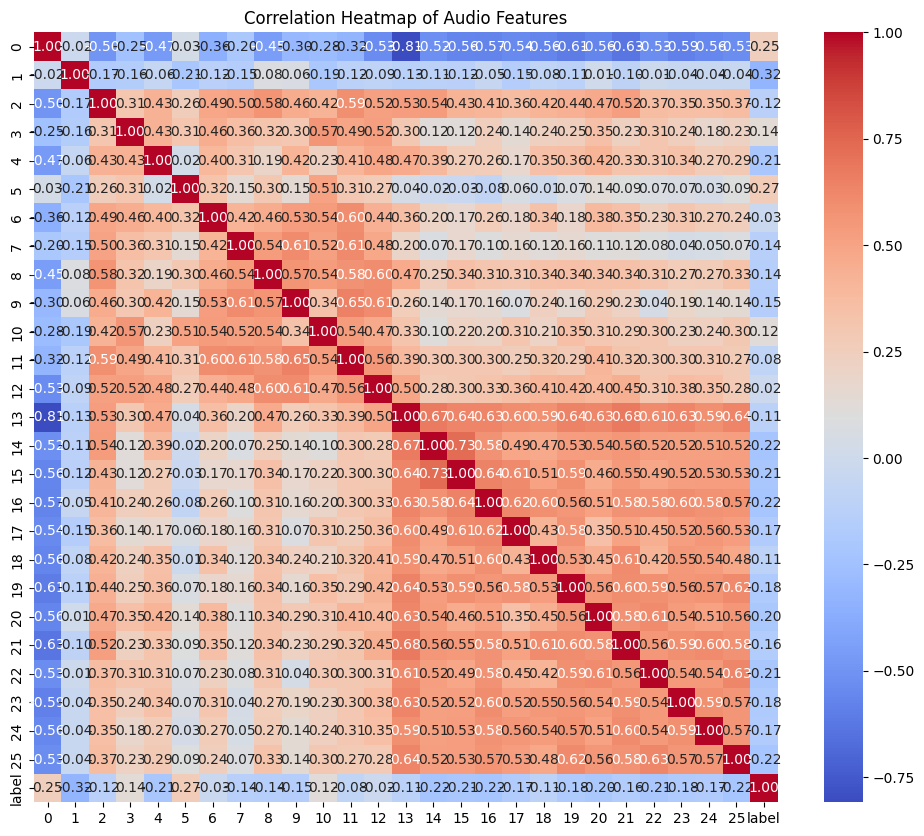

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(df_features.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Audio Features")
plt.show()


In [11]:
#df_features.drop(columns={14}, inplace=True)
#df_features# 14 was highly correlated

In [ ]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = df_features.drop(columns=['label'])
y = df_features['label']
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train_split)
y_pred = clf.predict(X_val_split)
print(classification_report(y_val_split, y_pred))


              precision    recall  f1-score   support

           0       0.82      1.00      0.90      2159
           1       0.00      0.00      0.00       478

    accuracy                           0.82      2637
   macro avg       0.41      0.50      0.45      2637
weighted avg       0.67      0.82      0.74      2637



c:\Users\Sherwyn\Downloads\Projects\Python\DeepFake\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Sherwyn\Downloads\Projects\Python\DeepFake\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Sherwyn\Downloads\Projects\Python\DeepFake\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [23]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Assuming df_features is already created with 26 features and a 'label' column
# df_features shape: (number_of_samples, 27) -- 26 features + label

# Separate features and labels
X = df_features.drop(columns=['label'])
y = df_features['label']

# Perform oversampling to balance the classes
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)
print("Resampled distribution:", Counter(y_resampled))
# This should print a balanced distribution, e.g.:
# Counter({0: 10660, 1: 10660})

# Split the oversampled dataset into training and validation sets
X_train_res, X_val_res, y_train_res, y_val_res = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# Scale the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_val_scaled = scaler.transform(X_val_res)

# Train a Random Forest classifier on the oversampled, scaled training data
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train_res)

# Predict on the validation set
y_pred = clf.predict(X_val_scaled)

# Evaluate the classifier
print("Classification Report for Random Forest (with oversampling):")
print(classification_report(y_val_res, y_pred))


Resampled distribution: Counter({0: 10660, 1: 10660})
Classification Report for Random Forest (with oversampling):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2154
           1       1.00      1.00      1.00      2110

    accuracy                           1.00      4264
   macro avg       1.00      1.00      1.00      4264
weighted avg       1.00      1.00      1.00      4264



In [13]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Step 1: Initialize the base XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Step 2: Set up the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Step 3: Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='f1_weighted',  # You could also use 'accuracy' or 'f1_macro'
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Step 4: Fit the model on training data (you can use PCA or original data here)
grid_search.fit(X_train_split, y_train_split)

# Step 5: Print best parameters
print("Best Hyperparameters from GridSearchCV:")
print(grid_search.best_params_)

# Step 6: Evaluate the best model on the validation set
best_model = grid_search.best_estimator_
y_pred_xgb = best_model.predict(X_val_split)

print("Classification Report for XGBoost:")
print(classification_report(y_val_split, y_pred_xgb))


Fitting 3 folds for each of 72 candidates, totalling 216 fits


c:\Users\Sherwyn\Downloads\Projects\Python\DeepFake\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [23:07:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Hyperparameters from GridSearchCV:
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2159
           1       0.98      0.96      0.97       478

    accuracy                           0.99      2637
   macro avg       0.99      0.98      0.98      2637
weighted avg       0.99      0.99      0.99      2637



In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Assume X_resampled and y_resampled are produced by RandomOverSampler as in your code:
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Convert oversampled arrays into a DataFrame, if desired:
df_resampled = pd.DataFrame(X_resampled)
df_resampled['label'] = y_resampled

# Split the oversampled data into training and validation sets
X_over = df_resampled.drop(columns=['label'])
y_over = df_resampled['label']
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_over, y_over, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val_split)

# Set up XGBoost with GridSearchCV (as before)
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train_split)
print("Best Hyperparameters from GridSearchCV:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_xgb = best_model.predict(X_val_scaled)
print("Classification Report for XGBoost:")
print(classification_report(y_val_split, y_pred_xgb))


Fitting 3 folds for each of 72 candidates, totalling 216 fits


c:\Users\Sherwyn\Downloads\Projects\Python\DeepFake\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [09:13:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Hyperparameters from GridSearchCV:
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2154
           1       1.00      1.00      1.00      2110

    accuracy                           1.00      4264
   macro avg       1.00      1.00      1.00      4264
weighted avg       1.00      1.00      1.00      4264

